In [12]:
# Carga de datos

import pandas as pd
import numpy as np

# Cargar el dataset desde el archivo CSV
data = pd.read_csv(r"C:\Users\CaRa801\OneDrive - HP Inc\Knowledge transfer Gerard Costa\Bootcamp en IA\Sprint 2\Lab4\Ejercicio autoevaluable 2\data\sign_mnist_train.csv")

# Separar las etiquetas y los píxeles
labels = data['label']
data = data.drop(columns='label')

# Convertir los valores de píxeles a un arreglo de NumPy
images = data.to_numpy()

# Reformar el array para convertirlo en imágenes de 28x28 píxeles
images = images.reshape(-1, 28, 28).astype(np.float32)


In [15]:
print("Etiquetas únicas:", np.unique(labels))

Etiquetas únicas: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


In [16]:
# Seleccion de una imagen

sample_image = images[0]


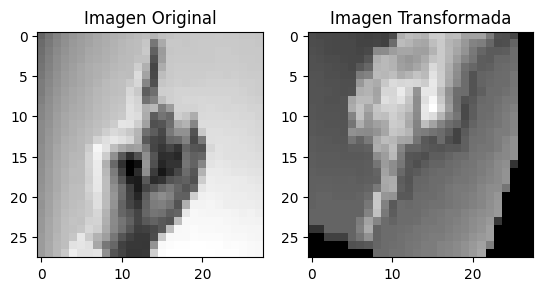

In [17]:
# Aplicacion de transformaciones

import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Definir las transformaciones
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(30),  # Rotación aleatoria
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Traslación
    transforms.RandomResizedCrop(28, scale=(0.8, 1.2)),  # Escalado
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Inversión de colores
    transforms.RandomVerticalFlip(),  # Flip aleatorio vertical
    transforms.RandomHorizontalFlip()  # Flip aleatorio horizontal
])

transformed_image = transform(sample_image)

# Visualización de la imagen original y transformada
fig, ax = plt.subplots(1, 2)
ax[0].imshow(sample_image, cmap='gray')
ax[0].set_title('Imagen Original')
ax[1].imshow(transformed_image, cmap='gray')
ax[1].set_title('Imagen Transformada')

plt.show()


In [18]:
# Exploracion de la red convolucional

from torch.utils.data import DataLoader, Dataset
import torch
from torchvision import transforms

# Normalizar los valores de los píxeles
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizar en el rango [0, 1]
])

# Crear un Dataset personalizado
class SignLanguageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

dataset = SignLanguageDataset(images, labels, transform=transform)


In [19]:
# Division del conjunto de datos

from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [20]:
# Creacion de los DataLoaders

subset_train_dataset, _ = torch.utils.data.random_split(train_dataset, [2000, len(train_dataset) - 2000])
train_loader = DataLoader(subset_train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)


In [21]:
# Definicion de la CNN

import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 25)  # 10 clases para el alfabeto de señas

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN()


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
print("Etiquetas únicas:", np.unique(labels))

Etiquetas únicas: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


In [24]:
# Entrenamiento de la red

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 50 == 0:  # Muestra progreso cada 50 lotes
            print(f"Epoch {epoch+1}, Batch {i}, Loss: {loss.item():.4f}", flush=True)

    print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")


Epoch 1, Batch 0, Loss: 40.3566


Epoch 1, Batch 50, Loss: 2.7524
Epoch 1 - Loss: 9.5101, Accuracy: 10.75%
Epoch 2, Batch 0, Loss: 1.9028
Epoch 2, Batch 50, Loss: 0.9060
Epoch 2 - Loss: 1.4387, Accuracy: 56.70%
Epoch 3, Batch 0, Loss: 0.7636
Epoch 3, Batch 50, Loss: 0.4664
Epoch 3 - Loss: 0.5293, Accuracy: 83.95%
Epoch 4, Batch 0, Loss: 0.1725
Epoch 4, Batch 50, Loss: 0.2242
Epoch 4 - Loss: 0.2578, Accuracy: 91.95%
Epoch 5, Batch 0, Loss: 0.0256
Epoch 5, Batch 50, Loss: 0.0438
Epoch 5 - Loss: 0.2044, Accuracy: 93.90%


In [25]:
# Evaluacion del modelo

model.eval()
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_accuracy = 100 * correct / total
print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Validation Loss: 0.4583, Validation Accuracy: 87.32%
